In [44]:
# Imports
import torch
import torch_cluster
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torchsummary import summary
from tqdm.notebook import tqdm

import ogb
# print(ogb.__version__)

import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import time
import json
import copy
import random
import os.path as osp
from pprint import pprint

import importlib
import sys

sys.path.append('../')

import training
importlib.reload(training)
import graph_vis
importlib.reload(graph_vis)
import graph_creation
importlib.reload(graph_creation)
import utils
importlib.reload(utils)

from ogb.nodeproppred import Evaluator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [45]:
device = utils.set_seeds_and_device() 
dataset_cora,data_cora = training.load_dataset('Cora', "../training_data/datasets")

Using device: cpu
Random seed set to: 42


In [38]:
parameter_dicts = training.create_parameters_dict()

p_values: [1, 2]
q_values: [1, 2]


In [39]:
parameter_dict = {
            "embedding_dim": 128,
            "walk_length": 80,
            "context_size": 10,
            "walks_per_node": 10,
            "num_negative_samples": 1,
            "sparse": True,
            "q":1,
            "p":1
        }
# d = 128, r = 10, l = 80, k = 10

Model initialization parameters provided as dictionary.
Model initialized
Starting training for 12 epochs...


Epoch 1/12 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 001, Loss: 7.7227, Acc: 0.1790, Duration: 98.66s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.1790


Epoch: 002, Loss: 5.2896, Acc: 0.2220, Duration: 93.58s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.2220


Epoch: 003, Loss: 3.9534, Acc: 0.2750, Duration: 87.01s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.2750


Epoch: 004, Loss: 3.0288, Acc: 0.3300, Duration: 85.61s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.3300


Epoch: 005, Loss: 2.3910, Acc: 0.3760, Duration: 88.46s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.3760


Epoch: 006, Loss: 1.9512, Acc: 0.4200, Duration: 86.39s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.4200


Epoch: 007, Loss: 1.6414, Acc: 0.4520, Duration: 113.79s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.4520


Epoch: 008, Loss: 1.4234, Acc: 0.4940, Duration: 140.16s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.4940


Epoch: 009, Loss: 1.2692, Acc: 0.5350, Duration: 135.41s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.5350


Epoch: 010, Loss: 1.1619, Acc: 0.5590, Duration: 150.04s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.5590


Epoch: 011, Loss: 1.0859, Acc: 0.5850, Duration: 155.26s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.5850


Epoch: 012, Loss: 1.0315, Acc: 0.6130, Duration: 87.56s
Dataset name: load_dataset_Cora
    New best model saved with accuracy: 0.6130

Training finished.
Total elapsed time: 1322.06 seconds
Best test accuracy: 0.6130
Best model state saved to '../training_data/models/node2vec_'


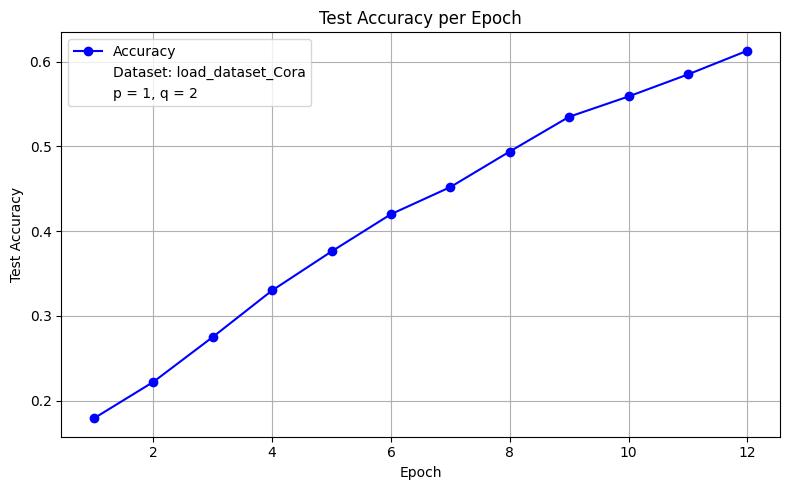

In [40]:
model = training.model_init(parameter_dict,data_cora)

loader, optimizer = training.set_loader_and_optimizer(model)
num_training_epochs = 12 # Or 201, etc.

best_state, training_history = training.model_training_n2v(
    model,
    value,
    data_cora,
    loader,
    optimizer,
    num_training_epochs,
    device,
    model_save_path='../training_data/models/node2vec_' # Example save path
)


In [41]:
model.eval()
with torch.no_grad():
    embeddings = model.embedding.weight.cpu().numpy()

embeddings

array([[-0.0896158 , -0.02676183,  0.06665601, ..., -0.38822493,
        -0.1638581 ,  0.20148337],
       [ 0.17415878,  0.07677878,  0.02922594, ...,  0.02761813,
        -0.00942727,  0.2128463 ],
       [-0.00661261, -0.08968952, -0.14136557, ..., -0.4079645 ,
         0.16520293, -0.24594106],
       ...,
       [-0.24104118,  0.01914842,  0.18580168, ...,  0.16415647,
        -0.12393414, -0.2506943 ],
       [ 0.0269185 ,  0.18349303, -0.28364033, ..., -0.00320607,
        -0.29969165,  0.77112216],
       [-0.0437653 ,  0.07954367, -0.17781338, ...,  0.20148318,
        -0.25368056,  0.35772333]], shape=(2708, 128), dtype=float32)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# X = embeddings from Node2Vec
X = embeddings
y = data_cora.y.cpu().numpy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "MLP": MLPClassifier(max_iter=500)
}

results = {}

for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} Test accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
        results[name] = acc
    except Exception as e:
        print(f"{name} failed: {e}")

# Summary table
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Test Accuracy"])
print("\nModel Comparison Summary:")
print(results_df.sort_values(by="Test Accuracy", ascending=False).to_string(index=False))


Training Logistic Regression...
Logistic Regression Test accuracy: 0.7362
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        70
           1       0.72      0.77      0.74        43
           2       0.91      0.89      0.90        84
           3       0.72      0.70      0.71       164
           4       0.70      0.68      0.69        85
           5       0.74      0.75      0.74        60
           6       0.66      0.69      0.68        36

    accuracy                           0.74       542
   macro avg       0.73      0.74      0.73       542
weighted avg       0.74      0.74      0.74       542


Training SVM...
SVM Test accuracy: 0.7620
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        70
           1       0.84      0.74      0.79        43
           2       0.92      0.92      0.92        84
           3       0.67      0.87      0.76       164
           4  